## 5.0  Analysis of POS Balance

> In this notebook I analyze the `pos cash balance` dataset which is described below:
> - Monthly balance snapshots of previous point of sales (POS) and cash loans that the applicant had with Home Credit

#### Analysis Summary:
> After analyzing the `pos cash balance` dataset I created a vector for each loan id with following columns:
>> - __COMPLETED_COUNT__: The number of completed accounts by bin size of 5( i.e. 1 means 0 to 5 accounts).
>> - __OVERDUE_ACTIVE_COUNT__: Flag to indicate if a client has an overdue account.

> I also created an aggregate table of four functions ('minimum', 'maximum', 'mean','standard deviation') `SK_ID_CURR` for each of the availble `float64` fields.  Each field would have a new column for each of the functions.  This created a total of 20 features.  By taking this approach I figure there will be many fields available during model selection that can be removed if there feature importance is zero.


In [30]:
#import helper ultility module
%load_ext autoreload
%aimport utils
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)

import numpy as np

%matplotlib inline

### 5.1 Import Datasets And Prepare ABT
> - Import the train and test datasets combined using a utility helper 
> - Create Activity Base Table (ABT) to group the fields by type.

In [32]:
dataset = utils.get_pos_cash_balances()

In [33]:
dataset.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31.00,48.00,45.00,Active,0.00,0.00
1,1715348,367990,-33.00,36.00,35.00,Active,0.00,0.00
2,1784872,397406,-32.00,12.00,9.00,Active,0.00,0.00
3,1903291,269225,-35.00,48.00,42.00,Active,0.00,0.00
4,2341044,334279,-35.00,36.00,35.00,Active,0.00,0.00


In [34]:
abt = utils.ABT(dataset)

In [35]:
float_table = abt.float_table
print("Total float64 types: {}".format(len(float_table)))
float_table 

Total float64 types: 5


,num,count,na_count,na_%,mean,std,min,25%,50%,75%,max
MONTHS_BALANCE,1,"10,001,358.00",0.00,0.00,-35.01,26.07,-96.00,-54.00,-28.00,-13.00,-1.00
CNT_INSTALMENT,2,"9,975,287.00","26,071.00",0.00,17.09,12.00,1.00,10.00,12.00,24.00,92.00
CNT_INSTALMENT_FUTURE,3,"9,975,271.00","26,087.00",0.00,10.48,11.11,0.00,3.00,7.00,14.00,85.00
SK_DPD,4,"10,001,358.00",0.00,0.00,11.61,132.71,0.00,0.00,0.00,0.00,"4,231.00"
SK_DPD_DEF,5,"10,001,358.00",0.00,0.00,0.65,32.76,0.00,0.00,0.00,0.00,"3,595.00"


In [36]:
# print description of each field in the integer ABT
field_table = utils.FieldsNames()
field_table.print('POS_CASH_balance.csv',float_table.index.values.tolist()) 

1) ['MONTHS_BALANCE']: Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly )
----------------------------------------
2) ['CNT_INSTALMENT']: Term of previous credit (can change over time)
----------------------------------------
3) ['CNT_INSTALMENT_FUTURE']: Installments left to pay on the previous credit
----------------------------------------
4) ['SK_DPD']: DPD (days past due) during the month of previous credit
----------------------------------------
5) ['SK_DPD_DEF']: DPD during the month with tolerance (debts with low loan amounts are ignored) of the previous credit
----------------------------------------


In [37]:
other_table = abt.other_table
print("Total string types: {}".format(len(other_table)))
other_table 

Total string types: 1


,num,count,na_count,na_%,unique,top,top_count,top_%
column,,,,,,,,
NAME_CONTRACT_STATUS,1,10001358,0,0.00,9,Active,9151119,0.91


In [38]:
# print description of each field in the string ABT
field_table = utils.FieldsNames()
field_table.print('POS_CASH_balance.csv',other_table.index.values.tolist()) 

1) ['NAME_CONTRACT_STATUS']: Contract status during the month
----------------------------------------


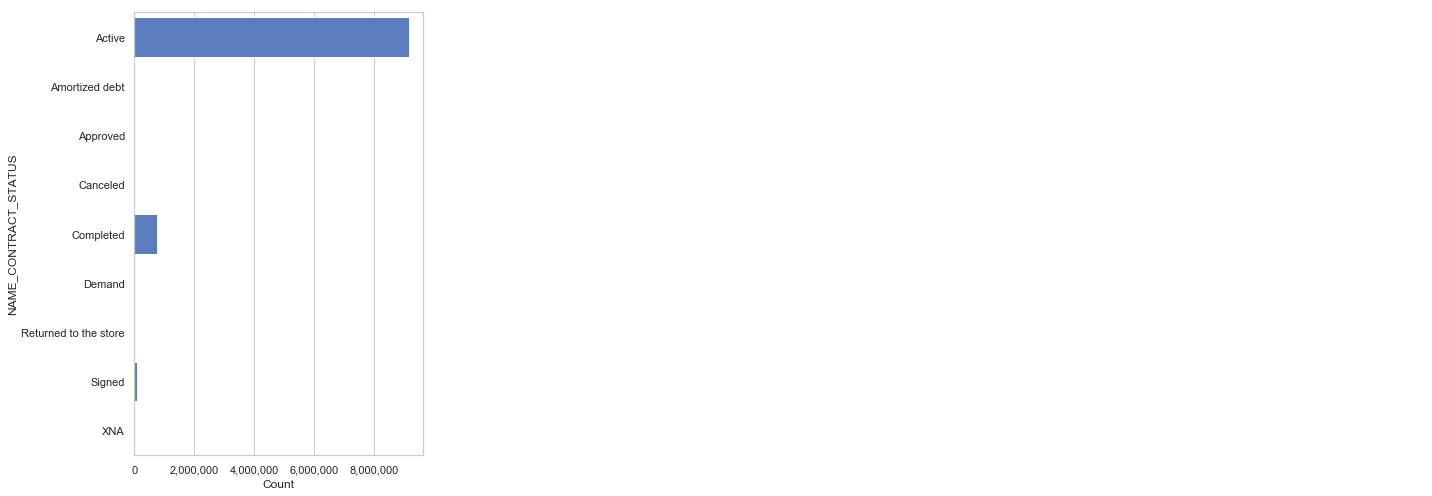

In [39]:
utils.plot_hbar(other_table.index,dataset)

### 5.2 Filter Dataset
> - Get the most recent record by `SK_ID_CURR` and `SK_ID_PREV`.


In [40]:
dataset_filter = dataset.sort_values(by=['MONTHS_BALANCE']).groupby(['SK_ID_CURR', 'SK_ID_PREV']).last().copy().reset_index() 

In [41]:
dataset_filter.head()

,SK_ID_CURR,SK_ID_PREV,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,100001,1369693,-53.00,4.00,0.00,Completed,0.00,0.00
1,100001,1851984,-93.00,4.00,0.00,Completed,0.00,0.00
2,100002,1038818,-1.00,24.00,6.00,Active,0.00,0.00
3,100003,1810518,-18.00,7.00,0.00,Completed,0.00,0.00
4,100003,2396755,-66.00,12.00,1.00,Active,0.00,0.00


### 5.3 Count Completed Installments
> - Count the number of completed installments loans by id.

In [42]:
def completed(df):
    name_flag = 'COMPLETED_FLAG'
    name = 'COMPLETED_COUNT'

    df[name_flag] = df['NAME_CONTRACT_STATUS'].apply(lambda x: 1 if x =='Completed'  else 0)
    
    df[name] = df.groupby('SK_ID_CURR')[name_flag].transform('sum')
    
    #lets increase the groups by 1 to make the base group 1
    df[name] = df[name].apply(lambda x:x+1)
    
    #drop column
    df.drop([name_flag],axis=1, inplace=True)

#apply function
completed(dataset_filter)

In [43]:
dataset_filter.dtypes

SK_ID_CURR                 int64
SK_ID_PREV                 int64
MONTHS_BALANCE           float64
CNT_INSTALMENT           float64
CNT_INSTALMENT_FUTURE    float64
NAME_CONTRACT_STATUS      object
SK_DPD                   float64
SK_DPD_DEF               float64
COMPLETED_COUNT            int64
dtype: object

In [44]:
dataset_filter.groupby('COMPLETED_COUNT').size()

COMPLETED_COUNT
1      43931
2     182962
3     204546
4     168290
5     121485
6      81498
7      51484
8      31915
9      20122
10     11855
11      7118
12      4094
13      2875
14      1671
15       945
16       572
17       369
18       264
19       177
20        19
21        62
22        45
25        26
dtype: int64

### 5.4 Count Overdue Active Counts
> - Count the number of overdue active installments loans by id.

In [45]:
def over_due_active(df):
    ''' Count the number of overdue active accounts'''
    
    name_flag = 'OVERDUE_FLAG'
    name = 'OVERDUE_ACTIVE_COUNT'
    
    def fun(x):
        over = x['SK_DPD_DEF']
        future_cnt = x['CNT_INSTALMENT_FUTURE']
                       
        if over > 0 and future_cnt > 0:
            return 1
        else:
            return 0

    df[name_flag] = df.apply(fun,axis=1)
    
    df[name] = df.groupby('SK_ID_CURR')[name_flag].transform('sum')
    
    #lets increase the groups by 1 to make the base group 1
    df[name] = df[name].apply(lambda x:x+1)
    
    #drop column
    df.drop([name_flag],axis=1, inplace=True)

#apply function
over_due_active(dataset_filter)

In [46]:
dataset_filter.head()

,SK_ID_CURR,SK_ID_PREV,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,COMPLETED_COUNT,OVERDUE_ACTIVE_COUNT
0,100001,1369693,-53.00,4.00,0.00,Completed,0.00,0.00,3,1
1,100001,1851984,-93.00,4.00,0.00,Completed,0.00,0.00,3,1
2,100002,1038818,-1.00,24.00,6.00,Active,0.00,0.00,1,1
3,100003,1810518,-18.00,7.00,0.00,Completed,0.00,0.00,3,1
4,100003,2396755,-66.00,12.00,1.00,Active,0.00,0.00,3,1


In [47]:
dataset_filter.groupby('OVERDUE_ACTIVE_COUNT').size()

OVERDUE_ACTIVE_COUNT
1    930577
2      5172
3       450
4       110
5        16
dtype: int64

### 5.5 Create Aggregate Dataset

In [48]:
#let get minimum, maximum, average and standard deviation
fun_agg = ['min', 'max', 'mean','std']

agg_fun_df = dataset.groupby('SK_ID_CURR')[float_table.index.values].agg(fun_agg)

#rename columns
agg_fun_df.columns = ["{}_{}".format(c[0],c[1].upper()) for c in agg_fun_df.columns.values.tolist()] 

#let fill nan values
agg_fun_df.fillna(0,inplace=True)
agg_fun_df.reset_index(inplace=True)

In [49]:
agg_fun_df.head()

,SK_ID_CURR,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_MEAN,MONTHS_BALANCE_STD,CNT_INSTALMENT_MIN,CNT_INSTALMENT_MAX,CNT_INSTALMENT_MEAN,CNT_INSTALMENT_STD,CNT_INSTALMENT_FUTURE_MIN,...,CNT_INSTALMENT_FUTURE_MEAN,CNT_INSTALMENT_FUTURE_STD,SK_DPD_MIN,SK_DPD_MAX,SK_DPD_MEAN,SK_DPD_STD,SK_DPD_DEF_MIN,SK_DPD_DEF_MAX,SK_DPD_DEF_MEAN,SK_DPD_DEF_STD
0,100001,-96.00,-53.00,-72.56,20.86,4.00,4.00,4.00,0.00,0.00,...,1.44,1.42,0.00,7.00,0.78,2.33,0.00,7.00,0.78,2.33
1,100002,-19.00,-1.00,-10.00,5.63,24.00,24.00,24.00,0.00,6.00,...,15.00,5.63,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,100003,-77.00,-18.00,-43.79,24.64,6.00,12.00,10.11,2.81,0.00,...,5.79,3.84,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,100004,-27.00,-24.00,-25.50,1.29,3.00,4.00,3.75,0.50,0.00,...,2.25,1.71,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,100005,-25.00,-15.00,-20.00,3.32,9.00,12.00,11.70,0.95,0.00,...,7.20,3.61,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### 5.6 Select Final Features and Merge Datasets
> - Select the `COMPLETED_COUNT`, `OVERDUE_ACTIVE_COUNT` and all from aggregate table as final features.

In [50]:
features= ['COMPLETED_COUNT','OVERDUE_ACTIVE_COUNT']
dataset_final = dataset_filter.groupby('SK_ID_CURR').first()[features].reset_index()

#set max values
utils.applyMax(['OVERDUE_ACTIVE_COUNT'],dataset_final,percent=99.9)
utils.applyMax(['COMPLETED_COUNT'],dataset_final)

In [51]:
dataset_final = dataset_final.merge(agg_fun_df,
                                      how='left', 
                                      on='SK_ID_CURR',
                                      validate='one_to_one')

In [52]:
dataset_final.head()

,SK_ID_CURR,COMPLETED_COUNT,OVERDUE_ACTIVE_COUNT,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_MEAN,MONTHS_BALANCE_STD,CNT_INSTALMENT_MIN,CNT_INSTALMENT_MAX,CNT_INSTALMENT_MEAN,...,CNT_INSTALMENT_FUTURE_MEAN,CNT_INSTALMENT_FUTURE_STD,SK_DPD_MIN,SK_DPD_MAX,SK_DPD_MEAN,SK_DPD_STD,SK_DPD_DEF_MIN,SK_DPD_DEF_MAX,SK_DPD_DEF_MEAN,SK_DPD_DEF_STD
0,100001,3,1,-96.00,-53.00,-72.56,20.86,4.00,4.00,4.00,...,1.44,1.42,0.00,7.00,0.78,2.33,0.00,7.00,0.78,2.33
1,100002,1,1,-19.00,-1.00,-10.00,5.63,24.00,24.00,24.00,...,15.00,5.63,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,100003,3,1,-77.00,-18.00,-43.79,24.64,6.00,12.00,10.11,...,5.79,3.84,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,100004,2,1,-27.00,-24.00,-25.50,1.29,3.00,4.00,3.75,...,2.25,1.71,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,100005,2,1,-25.00,-15.00,-20.00,3.32,9.00,12.00,11.70,...,7.20,3.61,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [53]:
dataset_final.groupby('OVERDUE_ACTIVE_COUNT').size()

OVERDUE_ACTIVE_COUNT
1    335764
2      1488
dtype: int64

In [54]:
dataset_final.groupby('COMPLETED_COUNT').size()

COMPLETED_COUNT
1     37041
2    122019
3     78201
4     45111
5     25111
6     13738
7      7333
8      3933
9      4765
dtype: int64

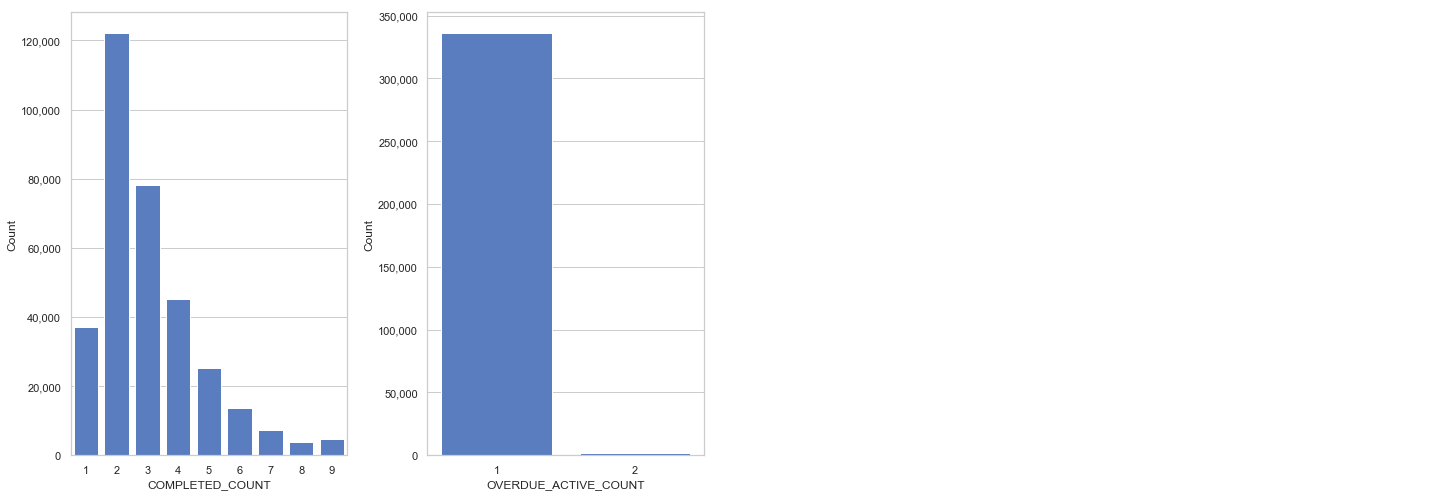

In [55]:
utils.plot_bar(features,dataset_final)

In [56]:
pos_cols_int = ['POS_BAL_COMPLETED_COUNT', 'POS_BAL_OVERDUE_ACTIVE_COUNT']

[f for f in dataset_final.columns if f != 'SK_ID_CURR' and f not in pos_cols_int]

['COMPLETED_COUNT',
 'OVERDUE_ACTIVE_COUNT',
 'MONTHS_BALANCE_MIN',
 'MONTHS_BALANCE_MAX',
 'MONTHS_BALANCE_MEAN',
 'MONTHS_BALANCE_STD',
 'CNT_INSTALMENT_MIN',
 'CNT_INSTALMENT_MAX',
 'CNT_INSTALMENT_MEAN',
 'CNT_INSTALMENT_STD',
 'CNT_INSTALMENT_FUTURE_MIN',
 'CNT_INSTALMENT_FUTURE_MAX',
 'CNT_INSTALMENT_FUTURE_MEAN',
 'CNT_INSTALMENT_FUTURE_STD',
 'SK_DPD_MIN',
 'SK_DPD_MAX',
 'SK_DPD_MEAN',
 'SK_DPD_STD',
 'SK_DPD_DEF_MIN',
 'SK_DPD_DEF_MAX',
 'SK_DPD_DEF_MEAN',
 'SK_DPD_DEF_STD']

### 5.7 Save Final Dataset To File

In [57]:
# rename columns  append all fields with 'POS_BAL_' except id field

col_name = []
for c in dataset_final.columns:
    if c =='SK_ID_CURR':
        col_name.append(c)
    else:
        col_name.append("POS_BAL_"+c)

dataset_final.columns = col_name

In [58]:
dataset_final.to_csv('data_pre_processed/1_5_pos_balances.csv',index=False)
print("File was saved.")

File was saved.
